# Parsing

Prior to entry in the model, the code will be parsed into a dependency structure. We do this to maximize the value of each 1-1 sample of code, since ordering of independent clauses is arbitrary.

In [3]:
import networkx as nx

def print_graph(G: nx.DiGraph):
    print("Nodes:")
    for node, data in G.nodes(data=True):
        print(f"Line {node}: {data['label']}")
    print("\nEdges:")
    for u, v in G.edges():
        print(f"Line {u} -> Line {v}")

In [5]:
from utils.parsing.code_parser import JavascriptParser

js_parser = JavascriptParser()

code = '''
var x = 1;
var y = 2;
var z = x + y;
'''

G = js_parser.get_dependency_graph(code)
print_graph(G)

Nodes:
Line 2: x
Line 3: y
Line 4: z

Edges:
Line 2 -> Line 4
Line 3 -> Line 4


## Javascript

{
    type: "Program",
    sourceType: "script",
    body: [
        {
            type: "VariableDeclaration",
            declarations: [
                {
                    type: "VariableDeclarator",
                    id: {
                        type: "Identifier",
                        name: "x",
                        loc: {start: {line: 2,column: 4},end: {line: 2,column: 5}}
                    },
                    init: {
                        type: "Literal",
                        value: 1,
                        raw: "1",
                        loc: {start: {line: 2,column: 8},end: {line: 2,column: 9}}
                    },
                    loc: {start: {line: 2,column: 4},end: {line: 2,column: 9}}
                }
            ],
            kind: "var",
            loc: {start: {line: 2,column: 0},end: {line: 2,column: 10}}
        },
        {
            type: "VariableDeclaration",
            declarations: [
                {
                    typ

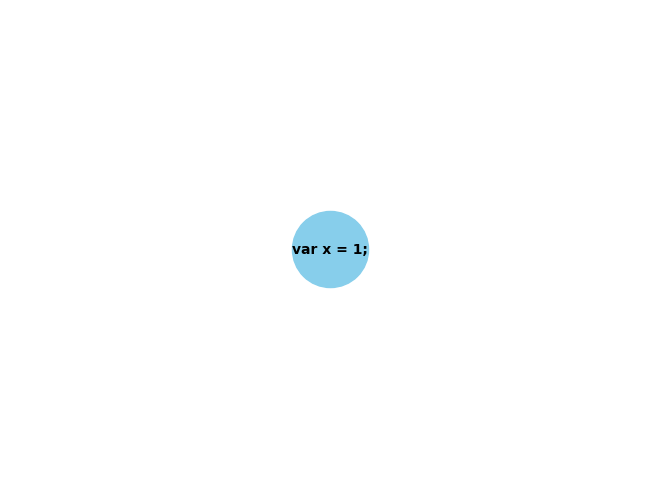

In [15]:
import esprima
import networkx as nx

def parse_js_code(js_code):
    """
    Parse the JavaScript code and return the AST (Abstract Syntax Tree).
    """
    return esprima.parseScript(js_code, loc=True)

def extract_dependencies(ast):
    """
    Extract dependencies from the AST. This function will return a list of tuples,
    where each tuple represents a dependency (line_a, line_b) meaning line_a depends on line_b.
    """
    dependencies = []
    line_to_code = {}

    def extract(node, parent_line=None):
        """
        Recursively extract dependencies from the AST node.
        """
        if hasattr(node, 'loc'):
            line_number = node.loc.start.line
            line_to_code[line_number] = js_code.splitlines()[line_number - 1].strip()
        else:
            line_number = None

        if parent_line and line_number:
            dependencies.append((parent_line, line_number))

        for key, value in node.items():
            if isinstance(value, dict):
                extract(value, line_number)
            elif isinstance(value, list):
                for item in value:
                    if isinstance(item, dict):
                        extract(item, line_number)

    extract(ast)
    return dependencies, line_to_code

def build_graph(dependencies, line_to_code):
    """
    Build a directed graph using NetworkX where each node is a line of code
    and each edge represents a dependency.
    """
    G = nx.DiGraph()

    for line_number, code in line_to_code.items():
        G.add_node(line_number, label=code)

    for a, b in dependencies:
        G.add_edge(a, b)

    return G

def js_code_to_graph(js_code):
    """
    Convert JavaScript code to a directed graph using esprima and networkx.
    """
    ast = parse_js_code(js_code)
    print(ast)
    dependencies, line_to_code = extract_dependencies(ast)
    graph = build_graph(dependencies, line_to_code)
    return graph

# Example usage
js_code = """
var x = 1;
var y = 2;
var z = x + y;
"""

graph = js_code_to_graph(js_code)

# Output the graph nodes and edges
print("Nodes:")
for node, data in graph.nodes(data=True):
    print(f"{node}: {data['label']}")

print("\nEdges:")
for a, b in graph.edges():
    print(f"{a} -> {b}")

# Optionally, visualize the graph (requires matplotlib)
import matplotlib.pyplot as plt

pos = nx.spring_layout(graph)
labels = {node: data['label'] for node, data in graph.nodes(data=True)}
nx.draw(graph, pos, with_labels=True, labels=labels, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold')
plt.show()


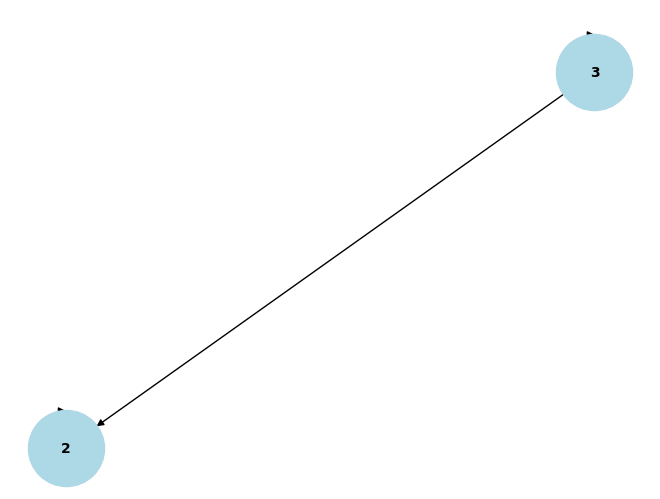

In [7]:
import esprima
import networkx as nx
import matplotlib.pyplot as plt

def parse_js_to_ast(js_code):
    """
    Parse the JavaScript code into an AST using esprima.
    """
    return esprima.parseScript(js_code, loc=True)

def build_graph_from_ast(ast):
    """
    Build a directed graph from the AST where each node represents a line of code.
    """
    graph = nx.DiGraph()

    def add_node(graph, node, parent=None):
        """
        Recursively add nodes to the graph from the AST.
        """
        if not node:
            return

        if hasattr(node, 'loc') and node.loc:
            start_line = node.loc.start.line
            end_line = node.loc.end.line
            for line in range(start_line, end_line + 1):
                if line not in graph:
                    graph.add_node(line, code=line)
                if parent:
                    graph.add_edge(parent, line)
            parent = line

        # Traverse child nodes
        for child_name, child in node.__dict__.items():
            if isinstance(child, list):
                for c in child:
                    if isinstance(c, esprima.nodes.Node):
                        add_node(graph, c, parent)
            elif isinstance(child, esprima.nodes.Node):
                add_node(graph, child, parent)

    add_node(graph, ast)
    return graph

def draw_graph(graph):
    """
    Draw the directed graph using matplotlib.
    """
    pos = nx.spring_layout(graph)
    labels = {node: node for node in graph.nodes()}
    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
    plt.show()

# Example JavaScript code
js_code = """
var x = 1;
var y = 2;
"""

# Parse the JS code into an AST
ast = parse_js_to_ast(js_code)

# Build the directed graph from the AST
graph = build_graph_from_ast(ast)

# Draw the graph
draw_graph(graph)
